In [1]:
!pip install iterative-stratification

In [43]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 64.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.5 MB/s eta 0:00:00:00:0100:01


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score , f1_score , precision_score , recall_score
import streamlit as st
import joblib
import io
import requests
from io import BytesIO

In [3]:
df=pd.read_csv('/kaggle/input/moderation/train.csv')

## Understand the data

### Subtask:
Explore the dataset to understand the structure and content of the comments and their associated toxicity labels. This will involve looking at descriptive statistics, value counts, and potentially visualizing the distribution of the different toxicity types.


In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Reasoning**:
Display the columns and their data types, get a summary of the DataFrame, and calculate descriptive statistics for the numerical columns to understand the dataset structure and content.



In [5]:
print(df.columns)
print(df.dtypes)
df.info()
df.describe()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
df.duplicated().sum()

0

**Reasoning**:
Visualize the distribution of each toxicity type to understand the class imbalance.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


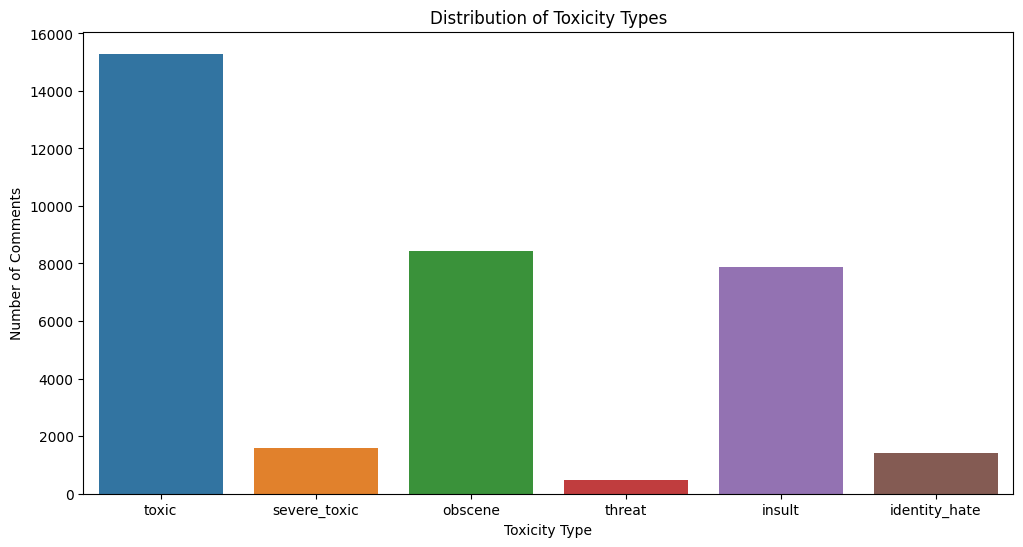

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plt.figure(figsize=(12, 6))
sns.barplot(x=toxicity_columns, y=df[toxicity_columns].sum().values)
plt.title('Distribution of Toxicity Types')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.show()

## Data preprocessing

### Subtask:
Clean and prepare the text data for model training. This will likely include steps like removing punctuation, converting text to lowercase, tokenization, and potentially removing stop words or stemming/lemmatization.


**Reasoning**:
Apply text cleaning and preprocessing steps to the 'comment_text' column, including removing punctuation, converting to lowercase, tokenization, removing stop words, and stemming.



In [9]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

stemmer = PorterStemmer()
stopwords_english = set(stopwords.words('english'))
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\w\s]', '', str(text))
    text = text.lower()
    tokens = text.split()
    cleaned_tokens = []
    for word in tokens:
        if word in stopwords_english:
            continue
        if not word.isalpha():
            continue
        try:
            stemmed = stemmer.stem(word)
            cleaned_tokens.append(stemmed)
        except RecursionError:
            continue
    return ' '.join(cleaned_tokens)

# The clean_text function is already defined in the previous successful execution,
# so we just need to re-apply it after increasing the recursion depth.
df['cleaned_comment_text'] = df['comment_text'].apply(clean_text)
print(df[['comment_text', 'cleaned_comment_text']].head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                cleaned_comment_text  
0  explan edit made usernam hardcor metallica fan...  
1  daww match background colour im seemingli stuc...  
2  hey man im realli tri edit war guy constantli ...  
3  cant make real suggest improv wonder section s...  
4                    sir hero chanc rememb page that  


**Reasoning**:
The previous attempt to clean the text resulted in a RecursionError, likely due to the `PorterStemmer` with very long words or specific patterns. To address this, I will increase the recursion depth limit and re-run the cleaning process.



**Reasoning**:
Increasing the recursion depth was not sufficient to resolve the `RecursionError` when using `PorterStemmer`. This suggests that the issue might be inherent in how `PorterStemmer` handles certain words or patterns within the dataset, or that the required recursion depth is excessively high. A more robust approach for stemming or lemmatization is needed. I will switch to using `WordNetLemmatizer` from `nltk` as it is generally more sophisticated and less prone to such recursion issues, and it provides lemmatization which is often preferred over stemming as it reduces words to their base or dictionary form. I will also ensure the NLTK wordnet corpus is downloaded.



In [10]:
test_df = pd.read_csv("/kaggle/input/moderation/test.csv")
test_labels_df = pd.read_csv("/kaggle/input/moderation/test_labels.csv")

In [11]:
test_df["cleaned_comment_text"] = test_df["comment_text"].apply(clean_text)

In [12]:
target_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# Ensure X_train and y_train are taken from the same DataFrame after cleaning
X_train = df["cleaned_comment_text"]
y_train = df[target_cols]
X_test = test_df["cleaned_comment_text"]
y_test = test_labels_df[target_cols]

In [13]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [14]:
test_df = test_df.reset_index(drop=True)
test_labels_df = test_labels_df.reset_index(drop=True)

valid_idx = (test_labels_df[target_cols] != -1).all(axis=1)

X_test_valid = test_df.loc[valid_idx, "cleaned_comment_text"].reset_index(drop=True)
y_test_valid = test_labels_df.loc[valid_idx, target_cols].reset_index(drop=True)
X_test_valid_tfidf = tfidf.transform(X_test_valid)

In [15]:
X_test_valid_tfidf = tfidf.transform(X_test_valid)

In [16]:
mskf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [17]:
fold = 1
acc_scores_lr = []
for train_idx, val_idx in mskf.split(X_train_tfidf, y_train):
    X_tr, X_val = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    log_reg_model = OneVsRestClassifier(
        LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=1000)
    )
    log_reg_model.fit(X_tr, y_tr)

    y_pred_val = log_reg_model.predict(X_val)

    # حساب الـ accuracy
    acc = accuracy_score(y_val, y_pred_val)
    acc_scores_lr.append(acc)

    print("="*60)
    print(f"Fold {fold} - Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred_val, target_names=target_cols))
    fold += 1

print("="*60)
print("Average Accuracy (LogReg):", np.mean(acc_scores_lr))


In [33]:

fold = 1
acc_scores_nb = []

for train_idx, val_idx in mskf.split(X_train_tfidf, y_train):
    # Split data for this fold
    X_tr, X_val = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Define model (Naive Bayes wrapped for multilabel classification)
    nb_model = OneVsRestClassifier(
        MultinomialNB(alpha=0.1, fit_prior=True)
    )
    nb_model.fit(X_tr, y_tr)

    # Predictions
    y_pred_val = nb_model.predict(X_val)

    # Accuracy
    acc = accuracy_score(y_val, y_pred_val)
    acc_scores_nb.append(acc)

    # Print results
    print("="*60)
    print(f"Fold {fold} - Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred_val, target_names=target_cols))

    fold += 1

print("="*60)
print("Average Accuracy (Naive Bayes):", np.mean(acc_scores_nb))

Fold 1 - Accuracy: 0.9118
Classification Report:
               precision    recall  f1-score   support

        toxic       0.90      0.53      0.67      5098
 severe_toxic       0.44      0.45      0.45       532
      obscene       0.85      0.58      0.69      2816
       threat       0.22      0.10      0.14       160
       insult       0.77      0.52      0.62      2626
identity_hate       0.37      0.26      0.31       469

    micro avg       0.80      0.52      0.63     11701
    macro avg       0.59      0.41      0.48     11701
 weighted avg       0.81      0.52      0.63     11701
  samples avg       0.05      0.04      0.04     11701



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2 - Accuracy: 0.9124
Classification Report:
               precision    recall  f1-score   support

        toxic       0.91      0.53      0.67      5098
 severe_toxic       0.43      0.45      0.44       531
      obscene       0.86      0.57      0.69      2816
       threat       0.33      0.14      0.20       159
       insult       0.78      0.51      0.62      2625
identity_hate       0.43      0.29      0.34       468

    micro avg       0.81      0.52      0.63     11697
    macro avg       0.62      0.42      0.49     11697
 weighted avg       0.82      0.52      0.63     11697
  samples avg       0.05      0.04      0.04     11697



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 - Accuracy: 0.9129
Classification Report:
               precision    recall  f1-score   support

        toxic       0.90      0.55      0.68      5098
 severe_toxic       0.45      0.45      0.45       532
      obscene       0.87      0.59      0.71      2817
       threat       0.20      0.09      0.13       159
       insult       0.77      0.52      0.62      2626
identity_hate       0.37      0.25      0.30       468

    micro avg       0.81      0.53      0.64     11700
    macro avg       0.59      0.41      0.48     11700
 weighted avg       0.82      0.53      0.64     11700
  samples avg       0.05      0.04      0.04     11700

Average Accuracy (Naive Bayes): 0.9123524951206766


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:


final_nb_model = OneVsRestClassifier(MultinomialNB(alpha=0.1, fit_prior=True))
final_nb_model.fit(X_train_tfidf, y_train)

joblib.dump(final_nb_model, "naive_bayes_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [35]:
nb_model = joblib.load("naive_bayes_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

target_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

def predict_text(text):
   
    text_tfidf = tfidf.transform([text])
    
    pred = nb_model.predict(text_tfidf)[0]
    
    return {label: int(pred[i]) for i, label in enumerate(target_cols)}


In [40]:
submission = pd.read_csv("/kaggle/input/moderation/sample_submission.csv")
print(submission.head())

                 id  toxic  severe_toxic  obscene  threat  insult  \
0  00001cee341fdb12    0.5           0.5      0.5     0.5     0.5   
1  0000247867823ef7    0.5           0.5      0.5     0.5     0.5   
2  00013b17ad220c46    0.5           0.5      0.5     0.5     0.5   
3  00017563c3f7919a    0.5           0.5      0.5     0.5     0.5   
4  00017695ad8997eb    0.5           0.5      0.5     0.5     0.5   

   identity_hate  
0            0.5  
1            0.5  
2            0.5  
3            0.5  
4            0.5  


In [ ]:
X_test_tfidf = tfidf.transform(test_df["cleaned_comment_text"])

y_pred_test = (dnn_model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)

submission = pd.DataFrame(y_pred_test, columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
submission.insert(0, "id", test_df["id"]) 

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv")
